# Proyecto

Objetivo: Analizar la seguridad de contraseñas con base en la lista de contraseñas y su frecuencia de uso

- Los problemas de clasificación predicen una lista ordenada o una clasificación de objetos, la manera en el que se realizó la consulta. Esto podría ser bastante práctico si lo que queremos es regresar la lista de contraseñas que alguien podría colocar al momento de ingresar su contraseña. 
- La clasificación predice una etiqueta y los problemas incluyen problemas binarios de "sí o no" como "si esta imagen es un corgi o un muffin de arándanos", así como problemas de clasificación múltiple como "si esto es bueno, malo o promedio". Con la clasificación, las respuestas correctas deben etiquetarse para que su algoritmo pueda aprender de ellas.
- Exactamente, que es lo que deseamos encontrar?
- Que tipo de visualizaciones se elige?

Fuente de la información:
1. Bruteforce Database Github
2. https://github.com/duyet/bruteforce-database
3. https://haveibeenpwned.com/Passwords **Pwned Passwords 20 GB.**
4. https://www.kaggle.com/search?q=passwords
5. https://github.com/robinske/password-data

Primero haremos una exploración de los datos:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import random
from torch.multiprocessing import Process, Queue, Lock
import multiprocessing as mp
import torch

In [2]:
data =pd.read_csv('passwords/pass (1).csv')
for i in range(2,100):
    filename = pd.read_csv('passwords/pass ('+str(i)+').csv')
    data = pd.concat([data,filename],axis=0)
data

,password,hash,count
0,1980290,083040BB6B1D95F2B8AC447B50D21DAB38DAFF16,13
1,tornadof,0A7709AD9837766F20156FF016ABF66F8036ABC1,13
2,vova87654,66221A7691CDC27D9D31071A0CFA0712C100C7D7,13
3,XpKvShrO,4CB7086C94AE4D82E519FF8F98D0DA1DA38DBE53,13
4,tvjgtl,9E1FD26A17D2EBE7C9FD4181EF49424C7091D484,13
...,...,...,...
6840,491144,4511C39CDA1EFE76964C79783B52053BA7CD09DD,69
6841,xeyfhm3477362341,E2EC663D721E9F22F5CF39D5AA27A89CE00172D0,69
6842,irontree4,350AA827594B47AF3BCB9256E2388EFB958C4529,69
6843,wh2t3v3r,221C76F1C2AD5883003AF5EB7A495A41580B87C5,69


## Perfilado de Datos

Para esto, vamos a ver algunas características de los datos, como sus valores nulos y duplicados.

In [3]:
data.isnull().sum()

password    2
hash        0
count       0
dtype: int64

In [4]:
data = data.dropna(axis=0)
data.isnull().sum()

password    0
hash        0
count       0
dtype: int64

Ahora, existen valores duplicados en cada documento, que son el conteo de contraseñas segmentado, por lo cual será adecuado sumar las cuentas de todos los duplicados
para obtener el número de veces que cada contraseña fue usada.

Adicionalmente, en este momento no haremos usos de las firmas hash, puesto que no son relevantes para nuestro caso de estudio

In [5]:
data = data.groupby(data['password']).agg({'count':sum}).reset_index()
print(data.shape)
data.head()

(677566, 2)


,password,count
0,!!!!!,401
1,!!!!!!,2304
2,!!!!!!!,386
3,!12345,312
4,!23456,347


## Exploración de los datos:

Veamos algunas de las contraseñas más utilizadas

In [6]:
data = data.sort_values(by='count',ascending=False)
data.head()

,password,count
43879,123456789,7016669
506981,qwerty,3599486
35227,111111,2900049
43856,12345678,2680521
223879,abc123,2670319


La cuenta de aquellas contraseñas que tienen únicamente valores numéricos:

In [7]:
# Variable que guardará el total de contraseñas con esta característica y las veces que fueron utilizadas
data_patrones = []

numeric = data[data['password'].str.isnumeric() == True].count()[0]
numeric_count_sum = data[data['password'].str.isnumeric() == True]['count'].sum()

print('Contraseñas formadas por números:')
print(numeric)
print('Suma del uso de contraseñas formadas por números')
print(numeric_count_sum)

data_patrones += 'Numeric only', numeric, numeric_count_sum

Contraseñas formadas por números:
142340
Suma del uso de contraseñas formadas por números
171260703


In [8]:
alpha = data[data['password'].str.isalpha() == True].count()[0]
alpha_count_sum = data[data['password'].str.isalpha() == True]['count'].sum()

print('Contraseñas formadas por letras:')
print(alpha)
print('Suma del uso de contraseñas formadas por letras')
print(alpha_count_sum)

data_patrones += 'Alpha only', alpha, alpha_count_sum

Contraseñas formadas por letras:
278189
Suma del uso de contraseñas formadas por letras
335503274


---
A continuación consideraremos que una contraseña corta es aquella con menos de 8 carácteres:

In [9]:
short_pass = data[data['password'].str.len() < 8].count()[0]
short_pass_count_sum = data[data['password'].str.len() < 8]['count'].sum()

print('Contraseñas cortas:')
print(short_pass)
print('Suma del uso de contraseñas cortas')
print(short_pass_count_sum)

data_patrones += 'Short Passwords', short_pass, short_pass_count_sum

Contraseñas cortas:
382452
Suma del uso de contraseñas cortas
477964360


---
Y analizamos aquellas que tienen carácteres poco comunes o poco usados, como guiones, signos de exclamación, etc.

In [10]:
special_chars = ['!','"','#','<','>','%','&','/','=',
                '(\?)','(\()','(\))',"'",'¡','¿','(\+)','~',']','}',
                '(\[)','{',',',';',':','(\.)','_','-','(\*)','(\^)']

special_chars = '|'.join(special_chars)
special_pass = data[data['password'].str.contains(special_chars) == True].count()[0]
special_pass_count_sum = data[data['password'].str.contains(special_chars) == True]['count'].sum()

print('Contraseñas cortas:')
print(special_pass)
print('Suma del uso de contraseñas cortas')
print(special_pass_count_sum)

data_patrones += 'Special Characters', special_pass, special_pass_count_sum

/home/oswald/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Contraseñas cortas:
2147
Suma del uso de contraseñas cortas
1977061


El siguiente paso es convertir las letras de cada contraseña a algún número, esto lo hacemos primero asignando cada carácter de la contraseña en ASCII y después estandarizando los tamaños, es decir dado que la contraseña que tiene mayor número de carácteres es 27, todas las contraseñas las codificaremos a un vector de tamaño 27 de manera que también le asignaremos un carácter que representa 'el espacio vacío' de manera que una vez codificados los distintos carácteres de una contraseña, las dimensiones restantes para sumar 27, corresponderán a un valor `-1` que representa que la contraseña no tiene carácteres en esa posición

In [11]:
from copy import copy


passes = copy(data.iloc[:,0].values.tolist())

max_len_pass = 0 # Vamos guardando la longitud de contraseña más grande
min_string = 1000 # Guardamos el ASCII más pequeño que nos encontramos

for i in range(len(passes)):
    passes[i] = list(map(ord,list(passes[i])))
    if len(passes[i]) > max_len_pass:
        max_len_pass = len(passes[i])
    
    for letter_ascii in passes[i]:
        if letter_ascii < min_string:
            min_string = letter_ascii

min_string -= 1 # min_string será el valor para el espacio vacío

for i in range(len(passes)):
    n = len(passes[i])
    #Llenamos cada contraseña para que tengan la misma longitud
    passes[i] = passes[i] + [min_string]*(max_len_pass-len(passes[i]))
    
    
passes = np.array(passes)
passes.shape

(677566, 27)

Enseguida hacemos un escalamiento para estas contraseñas con `MinMaxScaler`

In [12]:
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()
passes_std = ms.fit_transform(passes.reshape(-1,27))

def password_to_encode(password):
    '''
    Función que dada una contraseña, devuelve el encoding acomodado al tratamiento
    que tuvieron los datos de este documento.
    --------------------------------------------------------------
    :param password str: Cadena de texto que contiene la contraseña a convertir
    
    :returns array: Vector 27-dimensional codificado. 
    '''
    pass_vector = list(map(ord,list(password)))
    pass_vector += [min_string]*(max_len_pass-len(pass_vector))
    pass_vector = np.array(pass_vector)
    pass_vector = ms.transform(pass_vector.reshape(-1,27))
    
    return pass_vector
    
password_to_encode(data.iloc[:,0].values[0]) == passes_std[0]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True]])

Ahora procederemos a asignarle a cada contraseña un score de seguridad, dividiendo en intervalos uniformes el conjunto según su ordenamiento ya hecho.

Para esto, se asigna una puntuación a las contraseñas en función a su posicionamiento en el escalamiento, siendo aquellos que se encuentran en la cola inferior, los que tienen peor seguridad, mientras los que estén en la cola superior, tendrán un score de 30, la máxima seguridad.

In [13]:
n = 30
intervalo = passes_std.shape[0]//n

pass_security = np.zeros(len(passes))
intervalo_idx = 0
for i in range(n):
    for j in range(intervalo_idx,intervalo_idx+intervalo):
        pass_security[j] = i
        intervalo_idx += 1
print(intervalo_idx)
for j in range(intervalo_idx,len(passes_std)):
    pass_security[j] = n
pass_security = pass_security.astype(int)   

print()


677550



In [14]:
print(pass_security[-30:])

[29 29 29 29 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30]


Así, tenemos que las contraseñas se ven de la siguiente manera:

In [15]:
print(f'''
Password :{data.iloc[:,0][0]}
Codificacion: 
{passes_std[0]}    
Security : 
{pass_security[0]}
''')


Password :!!!!!
Codificacion: 
[0.17204301 0.19148936 0.20212766 0.21276596 0.22340426 0.23404255
 0.25555556 0.25806452 0.27777778 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]    
Security : 
0



In [16]:
'''
aux1 = pass_security[:]
aux2 = passes_std[:]
n = passwords[passwords.Security==1].count()[0]
idx_inicio = 0
inicio = 0
List = passwords.Security.unique()
print(pass_security.shape)
m = len(passwords.Security.unique())
while len(pass_security)< n*m:
        #print(len(pass_security)-n*m)
        
        for i in range(idx_inicio,passwords.Security.count()):
            if aux1[i] != inicio:
                fin = List[inicio+1]
                
                idx_fin = i
                print(idx_inicio, idx_fin,n//(idx_fin-idx_inicio))
                if inicio != 1:
                    elemento_agregar1 = np.tile(aux1[idx_inicio:idx_fin],n//(idx_fin-idx_inicio))
                    elemento_agregar2 = np.vstack([aux2[idx_inicio:idx_fin]]*(n//(idx_fin-idx_inicio)))

                    pass_security = np.concatenate((pass_security,elemento_agregar1))
                    passes_std = np.concatenate((passes_std,elemento_agregar2))
                break
        inicio = fin
        idx_inicio = idx_fin
'''
print()

Pasamos la seguridad a OHE:

In [17]:

from sklearn.preprocessing import OneHotEncoder

pass_security = pass_security.reshape(-1,1)
ohe = OneHotEncoder()
pass_security = ohe.fit_transform(pass_security).toarray()

Dividimos en set de entrenamiento y validación

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(passes_std, pass_security, test_size=0.2)

In [19]:
X_train.shape

(542052, 27)

In [20]:
y_train.shape

(542052, 31)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

Definimos la red neuronal:

In [22]:
class Pass_net(nn.Module):
    '''
    Definimos un modelo de red neuronal sobre el cual podamos 
    evaluar la exactitud del modelo.
    '''
    def __init__(self, in_features, hidden1, hidden2, out_features):
        '''
        Estructura de la red neuronal a utilizar.
        -----------------------------------------
        :param in_features int: Neuronas de entrada
        :param hidden1 int: Neuronas en la primer capa oculta
        :param hidden2 int: Neuronas en la segunda capa oculta
        :param out_features: Neuronas de salida
        '''
        super(Pass_net,self).__init__()
        
        self.fc1 = nn.Linear(in_features = in_features, out_features = hidden1,bias = False)
        self.fc2 = nn.Linear(in_features = hidden1, out_features = hidden2,bias = False)
        self.fc3 = nn.Linear(in_features = hidden2, out_features= out_features,bias = False)
        
        self.in_features = in_features
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.out_features = out_features
        

        
        
    def forward(self, X):
        '''
        Función feed-forward con activación sigmoide entre capas.
        ---------------------------------------------------------
        :param X [float]: Vector o matriz de neuronas de entrada .
        
        :returns [float]: Activaciones de la red en la última capa.
        '''
        capa_oculta1 = torch.sigmoid(self.fc1(X))
        capa_oculta2 = torch.sigmoid(self.fc2(capa_oculta1))
        salida = torch.sigmoid(self.fc3(capa_oculta2))
        
        return salida


    def back_propagate(self, X, Y):
        '''
        Función que hace un paso de backpropagation con la entrada X con salida correcta Y,
        Como la función de activación sigmoide ronda entre valores del 0 y 1, esta nunca los
        va a tocar, es por ello que consideramos un truncamiento en los valores 0.2,0.8 de tal
        manera que aquellos valores antes del primero, no se activarán (0) y después del segundo, 
        se activarán (1). Utiliza función de error cuadrada.
        -----------------------------------------------------------------------
        :param X [float]: Matriz o Vector de neuronas de entrada
        :param Y [float]: Matriz o Vector a predecir con la entrada X
        
        :returns [float]: Error de gradiente
        '''
        salida = self.forward(X)
        funcion_error = nn.MSELoss()
        
        error = funcion_error(torch.clamp(salida,0.1,0.9),
                               torch.clamp(Y,0.1,0.9))
                    
        error.backward()
        
        return error
        
    def train(self, train_X, train_Y, optimizer, ciclos=100):
        '''
        Función de entrenamiento para la red, la cual utiliza al conjunto
        de entrenamiento y la función de error definida en la función
        back_propagate(). Al finalizar, muestra una gráfica del error
        ------------------------------------------------------------
        :param train_X [float]: Datos de entrenamiento
        :param train_Y [float]: Etiquetas correspondientes a los datos
                                de entrenamiento.
        :param optimizar torch.optim: Algoritmo de optimización
        :ciclos int: Número de épocas de entrenamiento
        
        '''
        self.optimizer = optimizer
        criterio = torch.nn.MSELoss()
        errores = np.zeros(ciclos)
        
        for ciclo in range(ciclos):
            y_pred = self.forward(train_X)
            perdida = criterio(torch.clamp(y_pred,0.1,0.9),
                               torch.clamp(train_Y,0.1,0.9))
            errores[ciclo] = perdida.item()
            if ciclo%int(ciclos/15)==1:
                print(f'Errores al paso {ciclo}: {errores[ciclo]}')
            
            self.optimizer.zero_grad()
            self.back_propagate(train_X,train_Y)
            self.optimizer.step()
            
        if ciclos > 1:
            pasos = np.arange(ciclos)
            plt.plot(pasos, errores, label='Entrenamiento')

    def confusion(self, test_X, test_Y):
        '''
        Muestra la matriz de confusión que presenta los valores actuales de
        la red, respecto al conjunto de datos que se decida usar.
        '''
        
        y_pred = self.forward(test_X)
        #print(y_pred[:20])
        labels = []
        for salida in y_pred:
            label = []
            max_idx = max(salida)
            
            for i in range(7):
                if salida[i] == max_idx:
                    label.append(1.)
                else:
                    label.append(0.)
            labels.append(label)

        VP = 0
        VN = 0
        FP = 0
        FN = 0
        
        for i in range(len(test_Y)):

            if all(torch.tensor(labels[i])==test_Y[i]):
                VP += 1
                VN += 6
            else:
                FP += 1
                FN += 1
                VN += 5
            
        print(
        """
    VP ={:.<5}    FN={:.<5}
    FP ={:.<5}    VN={:.<5}
    
            """.format(VP,FN,FP,VN)) 
        

In [36]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]

Inicializamos la red:

In [41]:
Net = Pass_net(input_size,45,35,output_size)

print('CUDA:',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Net = Net.to(device)

CUDA: False


In [42]:
try:
    std_dict = torch.load('./red_neruonal_multicapa.pth', map_location=device)
    RedCIFAR.load_state_dict(std_dict)
    print("Modelo cargado.")
except Exception as e:
    print(e)
    print("Modelo nuevo.")

[Errno 2] No such file or directory: './red_neruonal_multicapa.pth'
Modelo nuevo.


<ipython-input-43-88dbb5280b25>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).detach().clone().type(torch.float).to(device)
<ipython-input-43-88dbb5280b25>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).detach().clone().type(torch.float).to(device)
<ipython-input-43-88dbb5280b25>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).detach().clone().type(torch.float).to(device)
<ipython-input-43-88dbb5280b25>:4: UserWarning: To copy construct fro

Errores al paso 1: 0.17705972492694855
Errores al paso 67: 0.1437937468290329
Errores al paso 133: 0.11899742484092712
Errores al paso 199: 0.10043875128030777
Errores al paso 265: 0.08649174869060516
Errores al paso 331: 0.07596338540315628
Errores al paso 397: 0.06797188520431519
Errores al paso 463: 0.061865612864494324
Errores al paso 529: 0.05716481804847717
Errores al paso 595: 0.05351727455854416
Errores al paso 661: 0.050664421170949936
Errores al paso 727: 0.048415910452604294
Errores al paso 793: 0.046630844473838806
Errores al paso 859: 0.04520415514707565
Errores al paso 925: 0.04405687376856804
Errores al paso 991: 0.04312907159328461
Modelo Guardado


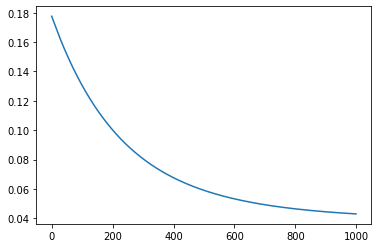

In [43]:
y_train = torch.tensor(y_train).detach().clone().type(torch.float).to(device)
X_train = torch.tensor(X_train).detach().clone().type(torch.float).to(device)
X_test = torch.tensor(X_test).detach().clone().type(torch.float).to(device)
y_test = torch.tensor(y_test).detach().clone().type(torch.float).to(device)

optimizer = optim.SGD(Net.parameters(),lr =0.05, momentum=0.05, weight_decay=0.02)

Net.train(X_train,y_train,optimizer,ciclos=1000)

torch.save(Net.state_dict(),"./red_neruonal_multicapa.pth")
print("Modelo Guardado")

Ahora vemos la exactitud del modelo:

In [46]:
print('Predicciones:')
for train in Pass_net.forward(X_train[:10]):
    print(train)
print('Etiquetas')
for test in y_test[:10]:
    print(torch.argmax(test))

suma = 0
for predicted,correct in zip(Net.forward(X_test),y_test):
    suma += torch.argmax(predicted)==torch.argmax(correct)

Predicciones:


TypeError: forward() missing 1 required positional argument: 'X'

In [45]:
print('Exactitud del modelo: ',suma/len(y_test))

Exactitud del modelo:  tensor(0.0331)


Por lo visto, no es tan útil este modelo pues se inclina a predecir la mitad de seguridad, esto es de esperarse pues no identifica la utilidad de las secuencias y minimiza el error estando en el centroide.